In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import timeit

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
from warnings import simplefilter
simplefilter(action='ignore', category=[FutureWarning,DeprecationWarning])

In [4]:
prices=pd.read_csv(r"E:\challenge\prices.csv")
price_adjusted=pd.read_csv(r"E:\challenge\prices-split-adjusted.csv")
fundamentals=pd.read_csv(r"E:\challenge\fundamentals.csv")
securities=pd.read_csv(r"E:\challenge\securities.csv")

In [5]:
# The EMA is a type of weighted moving average (WMA) that gives more weighting or importance to recent price data.
# Since new data carries greater weight, the EMA responds more quickly to price changes than the SMA.

In [6]:
price_adjusted.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [7]:
price_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [8]:
a=price_adjusted[price_adjusted["symbol"]=='YHOO'].copy()

In [9]:
a.reset_index(inplace=True)
a.drop(["index"],axis=1, inplace=True)

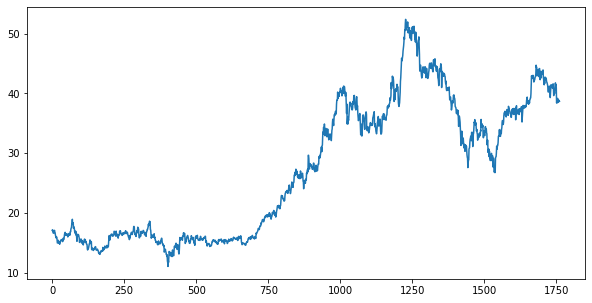

In [10]:
plt.figure(figsize=(10,5))
a["close"].plot(kind='line')

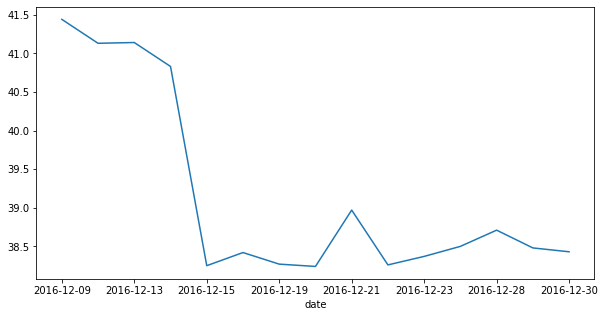

In [11]:
trialdf=a.tail(15)
trialdf.set_index('date',inplace=True)
plt.figure(figsize=(10,5))
trialdf["low"].plot(kind='line')

In [12]:
#########################################################
#for i in mylist:
 #a['ema12'+i]=np.nan
 #a['ema26'+i]=np.nan
 #a.loc[12,'ema12'+i]=a.loc[0:11][i].mean()
 #a.loc[26,'ema26'+i]=a.loc[0:25][i].mean()
 #for j in range(13, len(a.index)):
 # a.loc[j,'ema12'+i]=a.loc[j-1][i]*0.16 + a.loc[j-1]['ema12'+i]*0.84
 #for j in range(27, len(a.index)):
  #a.loc[j,'ema26'+i]=a.loc[j-1][i]*0.074 + a.loc[j-1]['ema26'+i]*0.926
 #a['macd'+i]=a['ema12'+i]-a['ema26'+i]
    
    
#a['trema']=np.nan
#a.loc[12,'trema']=a.loc[0:11]['open'].mean()
#for _ in range(len(a)):
    #a.trema = np.where(a.ind > 12, a.open.shift()*0.16 + a.trema.shift()*0.84, a.trema)
    
#########################################################

In [13]:
no_rows_a=len(a.index)
a.loc[no_rows_a]=a.loc[no_rows_a -1]  #to easily obtain the stats of previous 20 days.(of the day we want to predict the prices).otherwise, we would have to type a lot extra
a['ind']=a.index

### instead of above slow process using loop, use apply with a global variable

In [14]:
#calculate 12 day ema
a['ema12']=np.nan
a.loc[12,'ema12']=a.loc[0:11]['close'].mean()

prev_ema = np.nan

def calc_ema12(x):
    global prev_ema
    if x['ind'] > 12:
        if not np.isnan(a.loc[x['ind']-1, 'ema12']):
            prev_ema =  a.loc[x['ind']-1, 'open']*0.16 + a.loc[x['ind']-1, 'ema12']*0.84
            return prev_ema
        else:
            prev_ema = a.loc[x['ind']-1, 'open']*0.16 + prev_ema*0.84
            return prev_ema
    else:
        return x['ema12']


a["ema12"]=a.apply(lambda x: calc_ema12(x) ,axis=1)

In [15]:
#calculate 26 day ema
a['ema26']=np.nan
a.loc[26,'ema26']=a.loc[0:25,'close'].mean()

prev_ema=np.nan

def calc_ema26(x): 
    global prev_ema
    if x['ind'] > 26:
        if not np.isnan(a.loc[x['ind']-1 , 'ema26']):
            prev_ema=a.loc[x['ind']-1 , 'close']*0.074 + a.loc[x['ind']-1 ,'ema26']*0.926
            return prev_ema
        else:
            prev_ema=a.loc[x['ind']-1 , 'close']*0.074 + prev_ema*0.926
            return prev_ema
    else:
        return x['ema26']
 
    
a['ema26']=a.apply(lambda x: calc_ema26(x),axis=1)

In [16]:
a['macd']=a['ema12']-a['ema26']

In [17]:
#calculate OBV
a['obv']=np.nan
a.loc[1,'obv']=0

prev_obv=np.nan

def calc_obv(x):
    global prev_obv
    if(x['ind']>1):
        if not np.isnan(a.loc[x['ind']-1 , 'obv']):
            if(a.loc[x['ind']-1 , 'close']>a.loc[x['ind']-2 , 'close']):
                prev_obv=a.loc[x['ind']-1 , 'obv'] + a.loc[x['ind']-1 , 'volume']
            elif(a.loc[x['ind']-1 , 'close'] == a.loc[x['ind']-2 , 'close']):
                prev_obv=a.loc[x['ind']-1 , 'obv'] + 0
            else:
                prev_obv=a.loc[x['ind']-1 , 'obv'] - a.loc[x['ind']-1 , 'volume']
        else:
            if(a.loc[x['ind']-1 , 'close']>a.loc[x['ind']-2 , 'close']):
                prev_obv=prev_obv + a.loc[x['ind']-1 , 'volume']
            elif(a.loc[x['ind']-1 , 'close'] == a.loc[x['ind']-2 , 'close']):
                prev_obv=prev_obv + 0
            else:
                prev_obv=prev_obv - a.loc[x['ind']-1 , 'volume']
        return prev_obv
            
    else:
        return x['obv']
         

a['obv']=a.apply(lambda x: calc_obv(x), axis=1)

In [18]:
df=a.loc[600:][:].copy()    #main dataframe to be used for training and testing

In [19]:
df['ind']=df.index
df.reset_index(inplace=True)
df.drop(["index"],axis=1, inplace=True)
norows=len(df.index)

In [20]:
mylist=['open','close','low','high']

In [21]:
#bollinger bands
for i in mylist:
   df["mean"+i+"20"]=df.apply(lambda x: a.loc[x["ind"]-20 :x["ind"]-1][i].mean() , axis=1)
   df["std"+i+"20"]=df.apply(lambda x: a.loc[x["ind"]-20 :x["ind"]-1][i].std() , axis=1)

df['topbolly']=df['meanclose20']+2*df['stdclose20']
df['lowbolly']=df['meanclose20']-2*df['stdclose20']

In [22]:
#stochastic oscillator
df['st_osc']=df.apply(lambda x: (a.loc[x['ind']-1 ,'close']-a.loc[x['ind']-14:x['ind']-1 ,'close'].min())/(a.loc[x['ind']-14:x['ind']-1 ,'close'].max()-a.loc[x['ind']-14:x['ind']-1 ,'close'].min()),axis=1)

In [23]:
df.columns

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume', 'ind',
       'ema12', 'ema26', 'macd', 'obv', 'meanopen20', 'stdopen20',
       'meanclose20', 'stdclose20', 'meanlow20', 'stdlow20', 'meanhigh20',
       'stdhigh20', 'topbolly', 'lowbolly', 'st_osc'],
      dtype='object')

In [24]:
df.drop(['date','symbol','meanopen20', 'stdopen20',
       'meanclose20', 'stdclose20', 'meanlow20', 'stdlow20', 'meanhigh20',
       'stdhigh20','ema12','ema26','ind'],axis=1,inplace=True)

In [25]:
params=['macd', 'obv', 'topbolly', 'lowbolly', 'st_osc']
target=["open","close","low","high"]

In [26]:
testsize=int((norows-1)/5)
print(norows,',',testsize)

1163 , 232


In [27]:
x=df.loc[0:norows-2][params].copy()
scaler = MinMaxScaler()
x=pd.DataFrame(scaler.fit_transform(x),columns=params)

In [28]:
df.tail(10)

,open,close,low,high,volume,macd,obv,topbolly,lowbolly,st_osc
1153,38.660000,38.419998,38.270000,38.790001,13607200.0,-0.172202,771442000.0,42.546052,38.800948,0.059702
1154,38.400002,39.160000,38.240002,39.180000,15007900.0,-0.299397,757834800.0,42.641805,38.428194,0.002984
1155,39.080002,39.150002,38.970001,39.320000,8263600.0,-0.488307,772842700.0,42.611672,38.263328,0.223881
1156,38.689999,38.500000,38.259998,38.790001,11685600.0,-0.528927,764579100.0,42.573981,38.115019,0.220896
1157,38.459999,38.660000,38.369999,38.810001,3840100.0,-0.569389,752893500.0,42.575938,37.867062,0.026866
1158,38.590000,38.919998,38.500000,39.070000,4240300.0,-0.640510,756733600.0,42.543437,37.678563,0.074627
1159,39.119999,38.730000,38.709999,39.220001,4393500.0,-0.689056,760973900.0,42.386696,37.582304,0.152238
1160,38.759998,38.639999,38.480000,38.930000,4170200.0,-0.623705,756580400.0,42.178888,37.503112,0.095522
1161,38.720001,38.669998,38.430000,39.000000,6431600.0,-0.611811,752410200.0,42.049471,37.394529,0.068656
1162,38.720001,38.669998,38.430000,39.000000,6431600.0,-0.602514,758841800.0,42.048579,37.299420,0.084967


In [29]:
x.tail(10)

,macd,obv,topbolly,lowbolly,st_osc
1152,0.401866,0.859681,0.700518,0.713546,0.000000
1153,0.355989,0.880842,0.703145,0.702576,0.059702
1154,0.325691,0.867416,0.705610,0.691982,0.002984
1155,0.280693,0.882224,0.704834,0.687297,0.223881
1156,0.271018,0.874071,0.703864,0.683082,0.220896
1157,0.261380,0.862541,0.703914,0.676036,0.026866
1158,0.244439,0.866330,0.703078,0.670679,0.074627
1159,0.232876,0.870514,0.699043,0.667943,0.152238
1160,0.248442,0.866179,0.693693,0.665693,0.095522
1161,0.251275,0.862064,0.690362,0.662607,0.068656


In [30]:
testdata=np.array(df.loc[norows-1][params].copy())
testdata=scaler.transform(testdata.reshape(1,-1))
testdata

array([[0.2534896 , 0.86840997, 0.69033858, 0.65990387, 0.08496664]])

(10.5, -0.5)

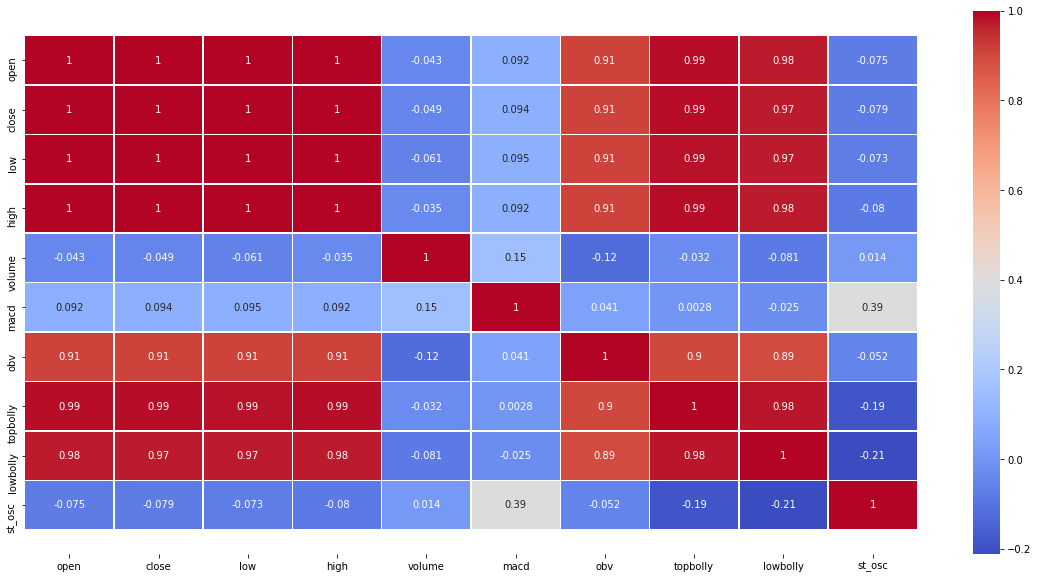

In [31]:
plt.figure(figsize=(20,10))
ax=sn.heatmap(df.corr(),annot=True, linewidth=0.5 , cmap='coolwarm') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [32]:
#for i in target:
x_train=x.loc[0:norows-1-testsize][:].copy()
x_test=x.loc[norows-testsize :][:].copy()
y_train=df.loc[0:norows-1-testsize]['close'].copy()
y_test=df.loc[norows-testsize :norows-2]['close'].copy()

In [33]:
x_train

,macd,obv,topbolly,lowbolly,st_osc
0,0.419159,0.053660,0.013555,0.026964,0.687500
1,0.437048,0.104123,0.014081,0.027093,0.887500
2,0.440777,0.071029,0.013986,0.026800,0.591549
3,0.427528,0.088902,0.013755,0.026715,0.718310
4,0.422571,0.075212,0.013386,0.026610,0.676056
...,...,...,...,...,...
926,0.163175,0.782747,0.487511,0.384894,0.355029
927,0.180299,0.769393,0.476806,0.385600,0.476440
928,0.239644,0.754012,0.461807,0.387124,0.000000
929,0.222674,0.772738,0.447848,0.391566,0.391752


In [34]:
y_train

0      15.580000
1      15.290000
2      15.380000
3      15.350000
4      15.360000
         ...    
926    29.690001
927    28.750000
928    29.510000
929    29.570000
930    29.059999
Name: close, Length: 931, dtype: float64

#### GridsearchCV on rf, lr and dec_tree

In [35]:
model_params={
              'random_forest':{'model':RandomForestRegressor(),'params':{'n_estimators':[5,10,100,500,1000],'min_samples_leaf':[3,5,7]}},
              'linear_regression':{'model':LinearRegression(),'params':{}},
              'decision_tree':{'model':DecisionTreeRegressor(),'params':{'min_samples_leaf':[7,10,13]}} 
             }
scores=[]

for i,j in model_params.items():
  clf=GridSearchCV(j['model'],j['params'],return_train_score=False, cv=10)
  clf.fit(x_train,y_train)
  #scores.append({'model':i,'best_parameters':clf.best_params_,'mean_score':clf.best_score_})

pd.DataFrame(scores)

""


In [36]:
#here, got R^2 value of -0.67  which means the random forest was really bad.  
#this also indicates the fact that random forest regressor performs poorly when the test data is out of bound of training data range 

In [37]:
clf=GridSearchCV (RandomForestRegressor(), {'n_estimators':[5,10,100,500,1000],'min_samples_leaf':[3,5,7]}, return_train_score=False, cv=3)
clf.fit(x_train,y_train)
resultscvdf=pd.DataFrame(clf.cv_results_)
resultscvdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019208,0.001579,0.003001,7.018853e-07,3,5,"{'min_samples_leaf': 3, 'n_estimators': 5}",-3.222005,0.108747,0.789362,-0.774632,1.752719,12
1,0.028335,0.001886,0.002001,1.808772e-06,3,10,"{'min_samples_leaf': 3, 'n_estimators': 10}",-2.868412,-0.033367,0.846219,-0.685187,1.584986,2
2,0.237475,0.011719,0.009875,2.653791e-03,3,100,"{'min_samples_leaf': 3, 'n_estimators': 100}",-3.032036,-0.027266,0.827173,-0.744043,1.655033,9
3,1.168428,0.031797,0.036003,2.828672e-03,3,500,"{'min_samples_leaf': 3, 'n_estimators': 500}",-3.043912,0.038848,0.823433,-0.727210,1.669176,5
4,2.104190,0.005355,0.069005,2.946623e-03,3,1000,"{'min_samples_leaf': 3, 'n_estimators': 1000}",-3.036245,0.001289,0.822930,-0.737342,1.659817,8
5,0.010674,0.000471,0.002005,1.988410e-06,5,5,"{'min_samples_leaf': 5, 'n_estimators': 5}",-3.416091,0.152635,0.786359,-0.825699,1.849865,15
6,0.020663,0.000462,0.001670,4.753165e-04,5,10,"{'min_samples_leaf': 5, 'n_estimators': 10}",-3.136867,0.295860,0.806311,-0.678232,1.750963,1
7,0.191679,0.000473,0.007670,4.709287e-04,5,100,"{'min_samples_leaf': 5, 'n_estimators': 100}",-3.074856,-0.011420,0.808488,-0.759263,1.671235,10
8,0.978253,0.014689,0.033334,4.727826e-04,5,500,"{'min_samples_leaf': 5, 'n_estimators': 500}",-3.037319,0.035541,0.812412,-0.729788,1.662208,6
9,2.153634,0.175660,0.079227,1.124027e-02,5,1000,"{'min_samples_leaf': 5, 'n_estimators': 1000}",-3.065503,0.059523,0.812649,-0.731110,1.679056,7


#### random forest regressor grid search

In [38]:
forestscores={}
noestim=[10,100,500,1000,2500,5000]
minsampleaf=[3,5,7,10]

for i in noestim:
    for j in minsampleaf:
       mymodel=RandomForestRegressor(min_samples_leaf=j, n_estimators= i,random_state=26)
       mymodel.fit(x_train,y_train)
       mypred=mymodel.predict(x_test)
       forestscores[str(i)+'trees , '+str(j)+'minleafsamples']=mymodel.score(x_test,y_test)
 
#forestscores
[[keys,values] for keys,values in forestscores.items() if values == max(forestscores.values())]

[['5000trees , 7minleafsamples', 0.5126732144071678]]

#### support vector regressor grid search

In [39]:
cvalues=[0.01,0.1,1,2,4,16,64,128,256,512]
gamvalues=[0.01,0.1,1,10,50,100,250]
coef0values=[0,0.5,1,2]

In [40]:
#linear kernel
linscores={}
for j in cvalues:
       mymodel=SVR(kernel='linear', C=j)
       mymodel.fit(x_train,y_train)
       mypred=mymodel.predict(x_test)
       linscores['C ='+str(j)]=mymodel.score(x_test,y_test)
        
#linscores
[[param,score] for param,score in linscores.items() if score == max(linscores.values())]

[['C =16', 0.963307533966351]]

In [41]:
#poly kernel
polyscores={}
for i in cvalues:
    for j in coef0values:
        #for k in gamvalues:
           mymodel=SVR(kernel='poly', C=i, coef0=j)
           mymodel.fit(x_train,y_train)
           mypred=mymodel.predict(x_test)
           polyscores['C='+str(i)+',r='+str(j)]=mymodel.score(x_test,y_test)
        
#polyscores  +',gam'+str(k) , gamma=k
[[param,score] for param,score in polyscores.items() if score == max(polyscores.values())]

[['C=0.1,r=2', 0.9629801580586748]]

In [42]:
#rbf kernel
rbfscores={}
for i in cvalues:
    for j in gamvalues:
       mymodel=SVR(kernel='rbf', C=i, gamma=j)
       mymodel.fit(x_train,y_train)
       mypred=mymodel.predict(x_test)
       rbfscores['C='+str(i)+',gamma='+str(j)]=mymodel.score(x_test,y_test)
        
#rbfscores
[[param,score] for param,score in rbfscores.items() if score == max(rbfscores.values())]

[['C=512,gamma=0.1', 0.9596605534267306]]

#### multiple linear regression

In [43]:
mymodel=LinearRegression()
mymodel.fit(x_train,y_train)
y_pred=mymodel.predict(x_test)
r2_score(y_pred,y_test)

0.9617682505291721

#### regularized linear regression

In [44]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [45]:
alphas=[1e-06,0.00001,0.0001,0.001,0.01,0.1,1,10,100]
ridgescores={}
lassoscores={}

for i in alphas:
 reg_model=Ridge(alpha=i)
 reg_model.fit(x_train,y_train)
 y_pred=reg_model.predict(x_test)
 ridgescores['ridge_alpha '+str(i)]=(r2_score(y_pred,y_test))

for i in alphas:
 reg_model=Lasso(alpha=i)
 reg_model.fit(x_train,y_train)
 y_pred=reg_model.predict(x_test)
 lassoscores['lasso_alpha '+str(i)]=(r2_score(y_pred,y_test))

print([[param,score] for param,score in ridgescores.items() if score == max(ridgescores.values())])
print([[param,score] for param,score in lassoscores.items() if score == max(lassoscores.values())])

[['ridge_alpha 1e-06', 0.9617682424481947]]
[['lasso_alpha 0.01', 0.9625339762473051]]


#### predicting for the final day

In [46]:
answers={'open':[],'close':[],'low':[],'high':[]}

In [47]:
for i in target:
 x_train=x.loc[0:norows-1-testsize][:].copy()
 x_test=x.loc[norows-testsize :][:].copy()
 y_train=df.loc[0:norows-1-testsize][i].copy()
 y_test=df.loc[norows-testsize :norows-2][i].copy()
    
 model=SVR(kernel='poly', C=128, coef0=2)
 model.fit(x_train,y_train)
 answers[i].append(model.predict(testdata).item())

In [48]:
pd.DataFrame(answers)

,open,close,low,high
0,37.875894,36.849492,37.45323,38.088654
